# Equalizer Design

Your task is to design and implement a __two-band audio equalizer__ (i.e. a bass/treble basic tone control) using first-order __shelving filters__.

You will investigate the __transfer function of the first-order low-pass shelving filter__ and its __complementary high-pass form__. __Cascading__ both filter sections will then produce a two-band audio equalizer. You must decide the range of each frequency band and justify your choice. Use a fixed sampling frequency fs = 44.1 kHz in all your work. 

Your submission should include: 

1. A description of the equalizer’s architecture, including the transfer function of each shelving filter, the parameters selected, and a __block diagram__ of the overall system. It is not permitted to use the Matlab's filter design functions in the final submission.

2. __Magnitude response plots__ for each individual filter as well as the combined response of the equalizer for different gain parameters. For example, set the bass and treble gains at GLP = 6 dB and GHP = −3 dB, respectively. What is the magnitude response of each filter? What about the overall output response? Modify the bass and gain levels, what does the response look like now? 

3. A Matlab implementation of the equalizer (thoroughly commented) and all required files to run the script. For example, if your script is using a wav file as input, it should be included.

4. References to any sources consulted for this work. 

All submitted plots must have all axes labelled. If you are plotting multiple responses in the same figure please use different line colors and Matlab’s legend function to indicate which line is which. All __frequency-domain figures should be plotted using logarithmic__ scale for the x-axis and decibels for the y-axis. Return your work via MyCourses at the latest on Wednesday February 6, 2019 at 16:00. Make sure you attach all the necessary filters required to evaluate your submission

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Ubuntu'
# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18   # Time and Hz, i.e. labels
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18  # Time(x) tick values
plt.rcParams['ytick.labelsize'] = 18  # Hz(y) tick values
plt.rcParams['legend.fontsize'] = 17
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 20   # Title font

from asp.core import Wave, read_wave
from asp import PATHS
import numpy as np

from scipy.signal import freqz, lfilter

GLP = 6
GHP = -3


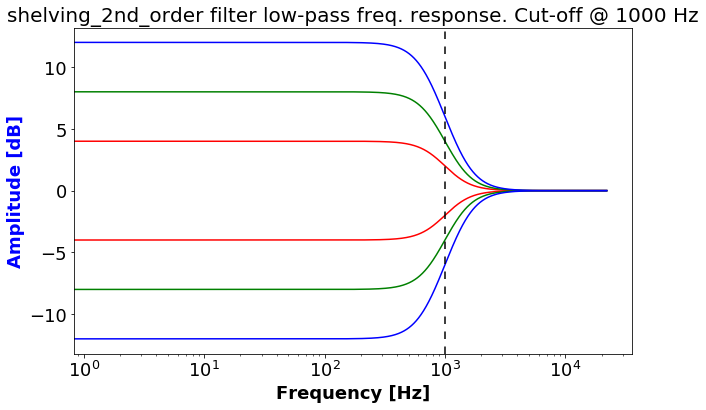

In [20]:
def shelving_1st_order(cut_off, gain, mode='low'):
    '''Shelving filter for bass
    
    Args:
        ys (numpy.array): 1D signals
        cut_off (float): Normalized cut-off frequency. 0 < cut_off < 1
        gain (float): gain in dB
    '''
    assert mode in ('low', 'high')
    
    gain        = 10 ** (gain / 20)          # NOTE: is it 20 or 40?
    wc          = 2 * np.pi * cut_off / 44100  # cut_off frequency in radians(0 <= wc <= pi)
    tan_term    = np.tan(wc / 2)
    gain_sqrt   = np.sqrt(gain)
    
    if mode == 'low':
        a0_prime = tan_term + gain_sqrt
        a1_prime = tan_term - gain_sqrt
        b0_prime = gain * tan_term + gain_sqrt
        b1_prime = gain * tan_term - gain_sqrt
    else:
        a0_prime = gain_sqrt * tan_term + 1
        a1_prime = gain_sqrt * tan_term - 1
        b0_prime = gain_sqrt * tan_term + gain
        b1_prime = gain_sqrt * tan_term - gain
    
    a1 = a1_prime / a0_prime
    b0 = b0_prime / a0_prime
    b1 = b1_prime / a0_prime
    
    return [b0, b1], [1, a1]

def shelving_2nd_order(cut_off, gain, mode):
    '''Shelving filter for bass
    
    Args:
        ys (numpy.array): 1D signals
        cut_off (float): Normalized cut-off frequency. 0 < cut_off < 1
        gain (float): gain in dB
    '''
    assert mode in ('low', 'high')
    
    gain        = 10 ** (gain / 20)          # NOTE: is it 20 or 40?
    wc          = 2 * np.pi * cut_off / 44100  # cut_off frequency in radians(0 <= wc <= pi)
    omega    = np.tan(wc / 2)
    omega_squared = omega ** 2
    gain_sqrt   = np.sqrt(gain)
    gain_double_sqrt = np.sqrt(gain_sqrt)
    two_sqrt = np.sqrt(2)
    

    b0_prime = gain_sqrt*omega_squared + two_sqrt*omega*gain_double_sqrt + 1
    b1_prime = 2*(gain_sqrt*omega_squared - 1)
    b2_prime = gain_sqrt*omega_squared - two_sqrt*omega*gain_double_sqrt + 1

    a0_prime = gain_sqrt + two_sqrt*omega*gain_double_sqrt + omega_squared
    a1_prime = 2*(omega_squared - gain_sqrt)
    a2_prime = gain_sqrt - two_sqrt*omega*gain_double_sqrt + omega_squared
    
    if mode == 'low':
        b = np.array([b0_prime, b1_prime, b2_prime]) / a0_prime * gain_sqrt
        a = np.array([a0_prime, a1_prime, a2_prime]) / a0_prime
    else:
        # H_hs(z) = G /H_ls(z)
        b = np.array([a0_prime, a1_prime, a2_prime]) / b0_prime * gain_sqrt
        a = np.array([b0_prime, b1_prime, b2_prime]) / b0_prime
    
    return b, a



def get_filter_frequency_response(filter, cut_off, mode='low'):
    assert mode in ('low', 'high')
    gains = (4, 8, 12)
    colors = ('r', 'g', 'b')
    nfft = 2**14
    samplerate = 44100

    fig, ax1 = plt.subplots(figsize = (10, 6))
    ax1.set_title(f'{filter.__name__} filter {mode}-pass freq. response. Cut-off @ {cut_off} Hz')

    for g, c in zip(gains, colors):
        b, a = filter(cut_off=cut_off, gain=g, mode=mode)
        w, h = freqz(b, a, nfft, whole=False)

        w *= 0.5 * samplerate / np.pi

        # plot amplitude in dB and frequency on log scale (essentially log-log)
        # we were right, just looking at it wrong
        ax1.semilogx(w, 20 * np.log10(abs(h)), c)
        ax1.set_ylabel('Amplitude [dB]', color=c)
        ax1.set_xlabel('Frequency [Hz]')

        b, a = filter(cut_off=cut_off, gain=-g, mode=mode)
        w, h = freqz(b, a, nfft, whole=False)

        w *= 0.5 * samplerate / np.pi

        # plot amplitude in dB and frequency on log scale (essentially log-log)
        # we were right, just looking at it wrong
        ax1.semilogx(w, 20 * np.log10(abs(h)), c)
        ax1.set_ylabel('Amplitude [dB]', color=c)
        ax1.set_xlabel('Frequency [Hz]')

    ax1.axvline(x=cut_off, label=f'cut-off at {cut_off} Hz', linestyle=(0, (5, 5)), color='black')

    from datetime import datetime
    plt.savefig(f'images/cut-off-{cut_off}Hz_{datetime.now()}.png')
    
get_filter_frequency_response(shelving_2nd_order, 1000)

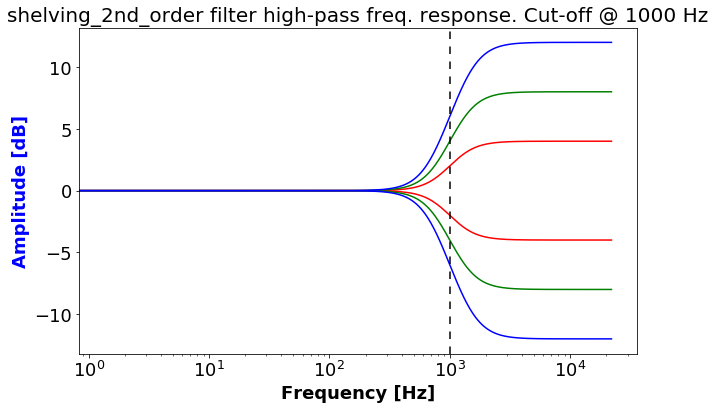

In [21]:
get_filter_frequency_response(shelving_2nd_order, 1000, mode='high')

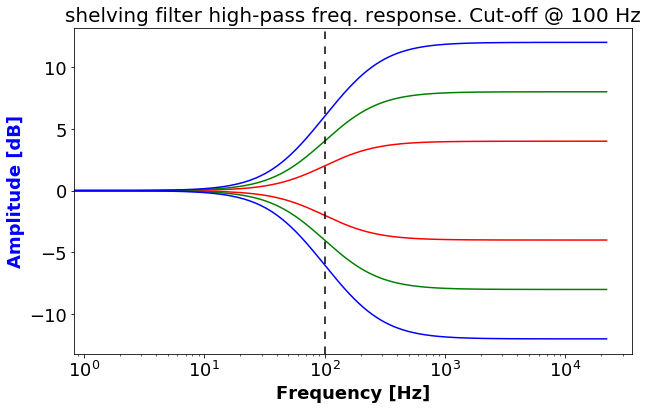

In [22]:
get_filter_frequency_response(shelving_1st_order, 100, mode='high')

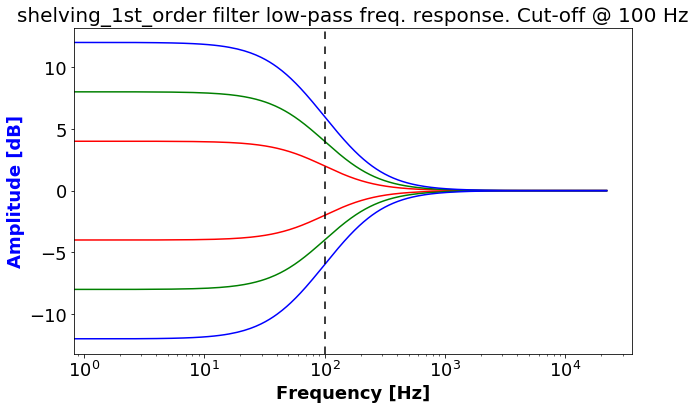

In [24]:
get_filter_frequency_response(shelving_1st_order, 100, mode='low')

In [11]:

violin = read_wave(PATHS.violin)

display(violin.make_audio())
violin.make_spectrum().plot()

16384

In [3]:
SAMPLERATE = 44100
a = np.zeros(SAMPLERATE)
a[SAMPLERATE//2] = 1.0

impulse = Wave(ys=a, ts=np.arange(SAMPLERATE)/SAMPLERATE, framerate=SAMPLERATE)
impulse_ref = Wave(ys=a, ts=np.arange(SAMPLERATE)/SAMPLERATE, framerate=SAMPLERATE)

## References

- http://www.musicdsp.org/files/Audio-EQ-Cookbook.txt